# Reproducing DeepDTA

Reference - https://academic.oup.com/bioinformatics/article/34/17/i821/5093245  
Data source - https://www.nature.com/articles/nbt.1990

In [1]:
# Import packages
import tensorflow as tf
import numpy as np
import csv
import random

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

In [2]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [5]:
# Load data
data = [] # list of lists of the form [smiles, sequence, pKd]


with open('/content/drive/MyDrive/dta_df.csv') as csvfile:
  reader = csv.reader(csvfile)
  next(reader) # skip header
  for row in reader:
      triplet = []
      triplet.append(row[0])
      triplet.append(row[1])
      triplet.append(float(row[2]))
      data.append(triplet)

len(data)

23785

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data[0] 

['CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC=C4)N',
 'MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQVTVDEVLAEGGFAIVFLVRTSNGMKCALKRMFVNNEHDLQVCKREIQIMRDLSGHKNIVGYIDSSINNVSSGDVWEVLILMDFCRGGQVVNLMNQRLQTGFTENEVLQIFCDTCEAVARLHQCKTPIIHRDLKVENILLHDRGHYVLCDFGSATNKFQNPQTEGVNAVEDEIKKYTTLSYRAPEMVNLYSGKIITTKADIWALGCLLYKLCYFTLPFGESQVAICDGNFTIPDNSRYSQDMHCLIRYMLEPDPDKRPDIYQVSYFSFKLLKKECPIPNVQNSPIPAKLPEPVKASEAAAKKTQPKARLTDPIPTTETSIAPRQRPKAGQTQPNPGILPIQPALTPRKRATVQPPPQAAGSSNQPGLLASVPQPKPQAPPSQPLPQTQAKQPQAPPTPQQTPSTQAQGLPAQAQATPQHQQQLFLKQQQQQQQPPPAQQQPAGTFYQQQQAQTQQFQAVHPATQKPAIAQFPVVSQGGSQQQLMQNFYQQQQQQQQQQQQQQLATALHQQQLMTQQAALQQKPTMAAGQQPQPQPAAAPQPAPAQEPAIQAPVRQQPKVQTTPPPAVQGQKVGSLTPPSSPKTQRAGHRRILSDVTHSAVFGVPASKSTQLLQAAAAEASLNKSKSATTTPSGSPRTSQQNVYNPSEGSTWNPFDDDNFSKLTAEELLNKDFAKLGEGKHPEKLGGSAESLIPGFQSTQGDAFATTSFSAGTAEKRKGGQTVDSGLPLLSVSDPFIPLQVPDAPEKLIEGLKSPDTSLLLPDLLPMTDPFGSTSDAVIEKADVAVESLIPGLEPPVPQRLPSQTESVTSNRTDSLTGEDSLLDCSLLSNPTTDLLEEFAPTAISAPVHKAAEDSNLISGFDVPEGSDKVAEDEFDPIPVLITKNPQGGHSRNSSGSSE

In [7]:
smiles = []
proteins = []
labels = []
random.shuffle(data)

for triplet in range(len(data)):
  smiles.append(data[triplet][0])
  proteins.append(data[triplet][1])
  labels.append(data[triplet][2])

In [8]:
print(smiles[0])
print(proteins[0])
print(labels[0])
# looks good!

CS(=O)(=O)N1CCN(CC1)CC2=CC3=C(S2)C(=NC(=N3)C4=C5C=NNC5=CC=C4)N6CCOCC6
MSTFRQEDVEDHYEMGEELGSGQFAIVRKCRQKGTGKEYAAKFIKKRRLSSSRRGVSREEIEREVNILREIRHPNIITLHDIFENKTDVVLILELVSGGELFDFLAEKESLTEDEATQFLKQILDGVHYLHSKRIAHFDLKPENIMLLDKNVPNPRIKLIDFGIAHKIEAGNEFKNIFGTPEFVAPEIVNYEPLGLEADMWSIGVITYILLSGASPFLGETKQETLTNISAVNYDFDEEYFSNTSELAKDFIRRLLVKDPKRRMTIAQSLEHSWIKAIRRRNVRGEDSGRKPERRRLKTTRLKEYTIKSHSSLPPNNSYADFERFSKVLEEAAAAEEGLRELQRSRRLCHEDVEALAAIYEEKEAWYREESDSLGQDLRRLRQELLKTEALKRQAQEEAKGALLGTSGLKRRFSRLENRYEALAKQVASEMRFVQDLVRALEQEKLQGVECGLR
5.7447274948966935


In [9]:
split = int(0.9 * len(smiles))
train_smiles = smiles[:split]
test_smiles = smiles[split:]
train_proteins = proteins[:split]
test_proteins = proteins[split:]
train_labels = labels[:split]
test_labels = labels[split:]

In [10]:
# Tokenize smiles
# train
tokenizer_smiles = Tokenizer(char_level = True)
tokenizer_smiles.fit_on_texts(train_smiles)

word_index_smiles = tokenizer_smiles.word_index
vocab_size_smiles = len(word_index_smiles)

train_sequences_smiles = tokenizer_smiles.texts_to_sequences(train_smiles)
train_padded_smiles = pad_sequences(train_sequences_smiles, truncating = "post", padding = "post", maxlen = 85) 

# test
test_sequences_smiles = tokenizer_smiles.texts_to_sequences(test_smiles)
test_padded_smiles = pad_sequences(test_sequences_smiles, truncating = "post", padding = "post", maxlen = 85) 

In [11]:
# Tokenize proteins
# train
tokenizer_proteins = Tokenizer(char_level = True)
tokenizer_proteins.fit_on_texts(train_proteins)

word_index_proteins = tokenizer_proteins.word_index
vocab_size_proteins = len(word_index_proteins)

train_sequences_proteins = tokenizer_proteins.texts_to_sequences(train_proteins)
train_padded_proteins = pad_sequences(train_sequences_proteins, truncating = "post", padding = "post", maxlen = 1200) 

# test
test_sequences_proteins = tokenizer_proteins.texts_to_sequences(test_proteins)
test_padded_proteins = pad_sequences(test_sequences_proteins, truncating = "post", padding = "post", maxlen = 1200) 

In [12]:
print(vocab_size_smiles) 
print(vocab_size_proteins) 

22
20


In [13]:
# convert to numpy arrays and check dimensions
train_smiles_array = np.array(train_padded_smiles)
test_smiles_array = np.array(test_padded_smiles)
train_proteins_array = np.array(train_padded_proteins)
test_proteins_array = np.array(test_padded_proteins)
train_labels_array = np.array(train_labels, dtype = "float32")
test_labels_array = np.array(test_labels, dtype = "float32")

print(f"Train smiles array shape: {train_smiles_array.shape}")
print(f"Test smiles array shape: {test_smiles_array.shape}")
print(f"Train proteins array shape: {train_proteins_array.shape}")
print(f"Test proteins array shape: {test_proteins_array.shape}")
print(f"Train labels array shape: {train_labels_array.shape}")
print(f"Test labels array shape: {test_labels_array.shape}")

Train smiles array shape: (21406, 85)
Test smiles array shape: (2379, 85)
Train proteins array shape: (21406, 1200)
Test proteins array shape: (2379, 1200)
Train labels array shape: (21406,)
Test labels array shape: (2379,)


# DeepDTA model

In [14]:
from keras.layers import Input, Embedding, Concatenate, Conv1D, GlobalAveragePooling1D, Dense, Dropout, Bidirectional, LSTM, Flatten, GlobalMaxPooling1D
from keras.models import Model

# Define two input layers
smile_input = Input((85,)) 
protein_input = Input((1200,)) 

# smiles encoder
embed_smiles = Embedding(vocab_size_smiles+1, 128, input_length=85)(smile_input)
conv_smiles = Conv1D(32, 4, activation = "relu")(embed_smiles)
conv_smiles = Conv1D(64, 6, activation = "relu")(conv_smiles)
conv_smiles = Conv1D(96, 8, activation = "relu")(conv_smiles)
max_smiles = GlobalMaxPooling1D()(conv_smiles)

# proteins encoder
embed_protein = Embedding(vocab_size_proteins+1, 128, input_length=1200)(protein_input)
conv_protein = Conv1D(32, 4, activation = "relu")(embed_protein)
conv_protein = Conv1D(64, 8, activation = "relu")(conv_protein)
conv_protein = Conv1D(96, 12, activation = "relu")(conv_protein)
max_protein = GlobalMaxPooling1D()(conv_protein)

# concatenate the two encoder outputs
concat_layer = Concatenate()([max_smiles, max_protein])

# decoder
output = Dense(1024, activation = "relu")(concat_layer)
output = Dropout(0.1)(output)
output = Dense(1024, activation = "relu")(output)
output = Dropout(0.1)(output)
output = Dense(512, activation = "relu")(output)
output = Dense(1)(output)

# define a model with a list of two inputs
model = Model(inputs = [smile_input, protein_input], outputs = output)

In [15]:
# define a model with a list of two inputs
model = Model(inputs = [smile_input, protein_input], outputs = output)

# compile model
optimizer = optimizers.Adam(learning_rate = 0.001)
model.compile(loss='mse', optimizer = optimizer, metrics=['mse'])

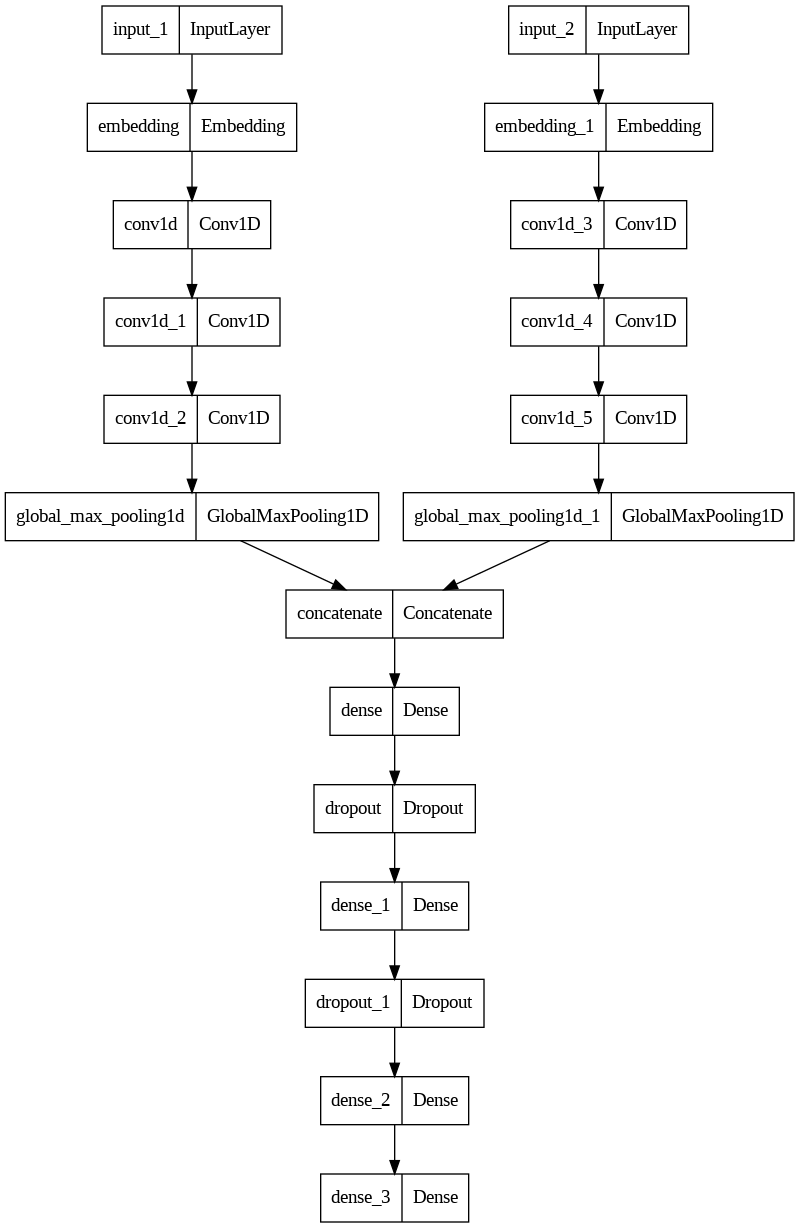

In [16]:
# visualize model
tf.keras.utils.plot_model(model)
#model.summary()

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit([train_smiles_array, train_proteins_array], train_labels_array, 
                    epochs = 100, batch_size = 256, validation_data = ([test_smiles_array, test_proteins_array], test_labels_array), callbacks = [early_stopping])

Epoch 1/100
84/84 [==============================] - 26s 112ms/step - loss: 2.9775 - mse: 2.9775 - val_loss: 0.5539 - val_mse: 0.5539
Epoch 2/100
84/84 [==============================] - 7s 85ms/step - loss: 0.5220 - mse: 0.5220 - val_loss: 0.4946 - val_mse: 0.4946
Epoch 3/100
84/84 [==============================] - 7s 85ms/step - loss: 0.4830 - mse: 0.4830 - val_loss: 0.4957 - val_mse: 0.4957
Epoch 4/100
84/84 [==============================] - 7s 86ms/step - loss: 0.4767 - mse: 0.4767 - val_loss: 0.5051 - val_mse: 0.5051
Epoch 5/100
84/84 [==============================] - 7s 87ms/step - loss: 0.4597 - mse: 0.4597 - val_loss: 0.4548 - val_mse: 0.4548
Epoch 6/100
84/84 [==============================] - 7s 87ms/step - loss: 0.4559 - mse: 0.4559 - val_loss: 0.4609 - val_mse: 0.4609
Epoch 7/100
84/84 [==============================] - 7s 88ms/step - loss: 0.4527 - mse: 0.4527 - val_loss: 0.4662 - val_mse: 0.4662
Epoch 8/100
84/84 [==============================] - 7s 88ms/step - loss: 

<Figure size 640x480 with 0 Axes>

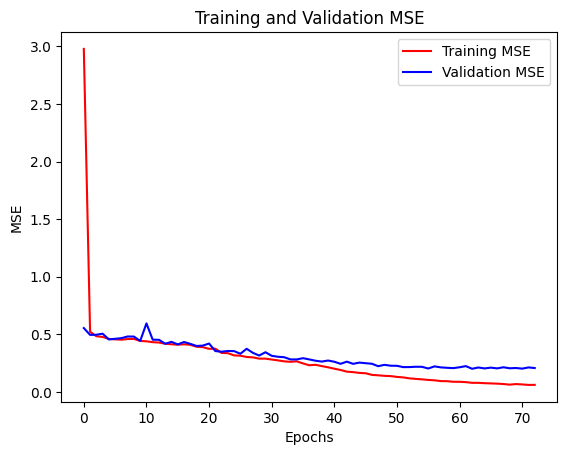

<Figure size 640x480 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mse=history.history['mse']
val_mse=history.history['val_mse']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(mse)) # Get number of epochs

#------------------------------------------------
# Plot training and validation mse per epoch
#------------------------------------------------
plt.plot(epochs, mse, 'r')
plt.plot(epochs, val_mse, 'b')
plt.title('Training and Validation MSE')
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend(["Training MSE", "Validation MSE"])

plt.figure()

In [19]:
# save model
model.save("deepDTA_10_11_2021.h5")

# Make predictions

In [20]:
# Function to predict drug-protein pKd

def predict_pKd(drug, protein):
  drug_sequence = tokenizer_smiles.texts_to_sequences([drug])
  drug_padded = pad_sequences(drug_sequence, truncating = "post", padding = "post", maxlen = 85) 
  protein_sequence = tokenizer_proteins.texts_to_sequences([protein])
  protein_padded = pad_sequences(protein_sequence, truncating = "post", padding = "post", maxlen = 1200) 
  prediction = model.predict([tf.expand_dims(drug_padded, axis = -1), tf.expand_dims(protein_padded, axis = -1)])
  
  return(prediction.item())

In [21]:
drug = test_smiles[31]
protein = test_proteins[531]
label = test_labels[1531]

print(label)
predict_pKd(drug = drug, protein = protein)

10.4089353929735
1/1 [==============================] - 0s 303ms/step


5.0214009284973145

In [22]:
test_labels.index(max(test_labels))

1531

1/1 [==============================] - 0s 29ms/step


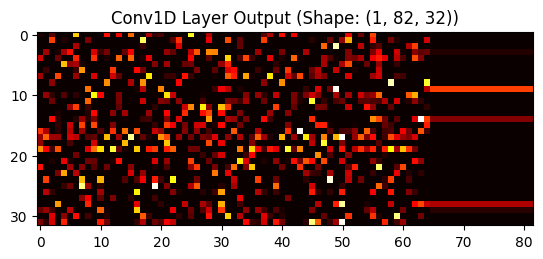

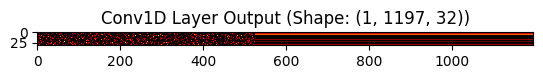

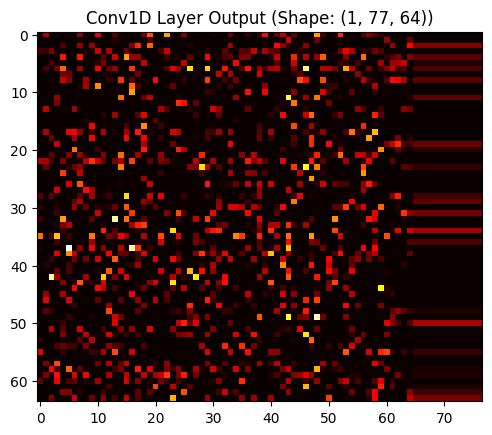

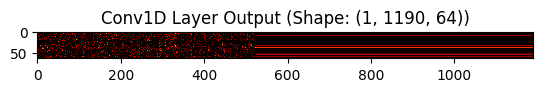

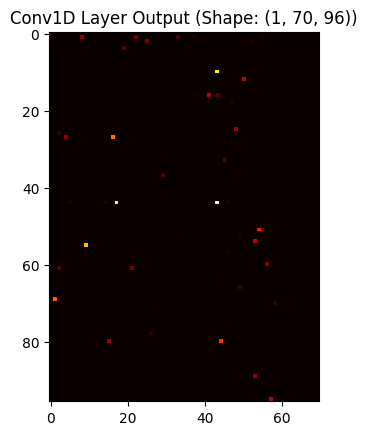

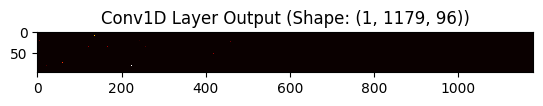

In [28]:
# Choose a random example from the test set
example_index = random.randint(0, len(test_smiles) - 1)
example_smiles = test_smiles_array[example_index]
example_proteins = test_proteins_array[example_index]

# Reshape the example to match the input shape of the model
example_smiles = np.expand_dims(example_smiles, axis=0)
example_proteins = np.expand_dims(example_proteins, axis=0)

# Get the intermediate outputs for the example
intermediate_outputs = visualization_model.predict([example_smiles, example_proteins])

# Plot the intermediate outputs
for layer_output in intermediate_outputs:
    plt.figure()
    plt.imshow(layer_output[0].T, cmap='hot', interpolation='nearest')
    plt.title(f"Conv1D Layer Output (Shape: {layer_output.shape})")

plt.show()


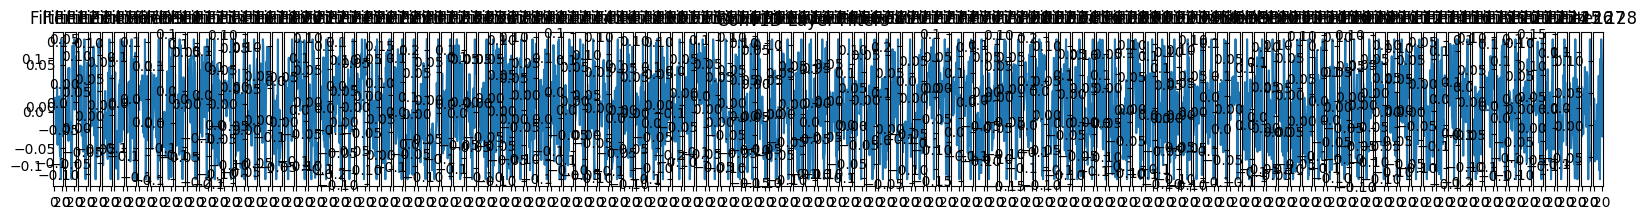

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Choose the index of the Conv1D layer you want to visualize
conv_layer_index = 2  # Modify this according to your desired layer index

# Get the weights of the chosen Conv1D layer
conv_layer_weights = model.layers[conv_layer_index].get_weights()[0]

# Reshape the weights to match the filter shape
filter_weights = np.squeeze(conv_layer_weights)

# Plot the filters
num_filters = filter_weights.shape[1]
fig, axs = plt.subplots(1, num_filters, figsize=(20, 2))
for i in range(num_filters):
    axs[i].plot(filter_weights[:, i])
    axs[i].set_title(f"Filter {i+1}")
plt.suptitle(f"Conv1D Layer Filters")
plt.show()


This code visualizes the filters of a specific Conv1D layer by accessing the layer's weights and plotting them. You can modify the conv_layer_index variable to choose the desired Conv1D layer to visualize. The code then reshapes the layer's weights and plots each filter separately


1/1 [==============================] - 0s 122ms/step
Features shape: (1, 192)


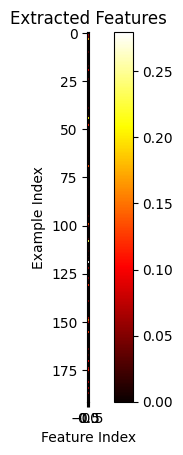

In [36]:
from tensorflow.keras.models import Model

# Create a new model that outputs the intermediate layer activations
feature_extraction_model = Model(inputs=model.input, outputs=model.get_layer('concatenate').output)

# Get the features for a specific input
example_index = 0  # Modify this according to the index of the example you want to extract features from
example_smiles = test_smiles_array[example_index]
example_proteins = test_proteins_array[example_index]

features = feature_extraction_model.predict([np.expand_dims(example_smiles, axis=0),
                                             np.expand_dims(example_proteins, axis=0)])

# Print the shape of the extracted features
print(f"Features shape: {features.shape}")

import matplotlib.pyplot as plt

# Visualize the features
plt.imshow(features.T, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Extracted Features")
plt.xlabel("Feature Index")
plt.ylabel("Example Index")
plt.show()




# Next steps - 
- https://www.sciencedirect.com/science/article/pii/S1046202319302762 (wonderful review)